In [ ]:
import jax.numpy as jnp
from jax import jit, vmap
import matplotlib.pyplot as plt

from core.quantum_error_correction_code import SurfaceCode
from core.perfect_maximum_likelihood_decoder import PMLD

In [2]:
p, nu = .01, 500
ERROR_PROBS = jnp.array([
    1 / (2 * (nu + 1)) * p,
    1 / (2 * (nu + 1)) * p,
    nu / (nu + 1) * p,
])

# Deformations that can be used
DEFORMATIONS = jnp.array([0,2,3])

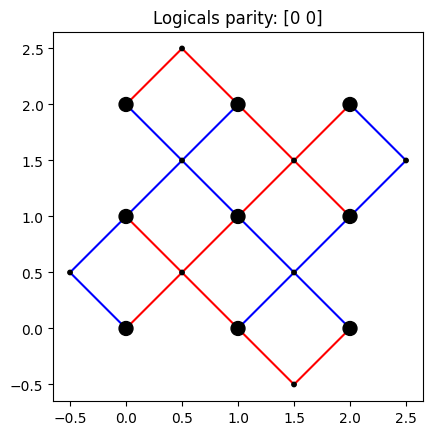

In [3]:
CODE = SurfaceCode(L=3)
parity_info = CODE.deformation_parity_info(jnp.zeros(3**2, dtype=jnp.int32))
CODE.show(parity_info)

In [4]:
m = DEFORMATIONS.shape[0] # Number of diferent deformations per qubit
n = CODE.hx_original.shape[1] # Number of data qubits that can have deformations
all_deformations = jnp.zeros(shape=(m**n, n), dtype=jnp.int32) + jnp.arange(0, m**n)[:, None]
all_deformations = (all_deformations // m**jnp.arange(0, n)) % m
all_deformations = DEFORMATIONS[all_deformations]
all_deformations

Array([[0, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 3, 3, ..., 3, 3, 3],
       [2, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]], dtype=int32)

In [5]:
all_deformations.reshape((-1, m**4, n)).shape

(243, 81, 9)

In [6]:
def error_rate(
    deformation: jnp.ndarray,
) -> float:
    parity_info = CODE.deformation_parity_info(deformation)
    decoder = PMLD(
        CODE, 
        ERROR_PROBS,
        parity_info
    )
    error_rate = decoder.exact_logical_error_rate()
    return error_rate

print(f"{error_rate(all_deformations[0]) = :.2%}")

error_rate(all_deformations[0]) = 0.17%


In [8]:
from time import time
t0 = time()

all_logical_error_rates = jnp.zeros(all_deformations.shape[0])
batch_size = m**3
for i, deformations_batch in enumerate(all_deformations.reshape((-1, batch_size, n))):
    all_logical_error_rates = all_logical_error_rates.at[i*batch_size:(i+1)*batch_size].set(
        vmap(error_rate)(deformations_batch)
    )
    procentage = (i+1) / (all_deformations.shape[0] // batch_size)
    remaining_time = (time()-t0) / procentage * (1 - procentage)
    print(f"{int(remaining_time/60/60):5d}h {int(remaining_time/60%60):02d}m {int(remaining_time%60):02d}s    ({procentage:.2%})"+10*" ", end='\r')

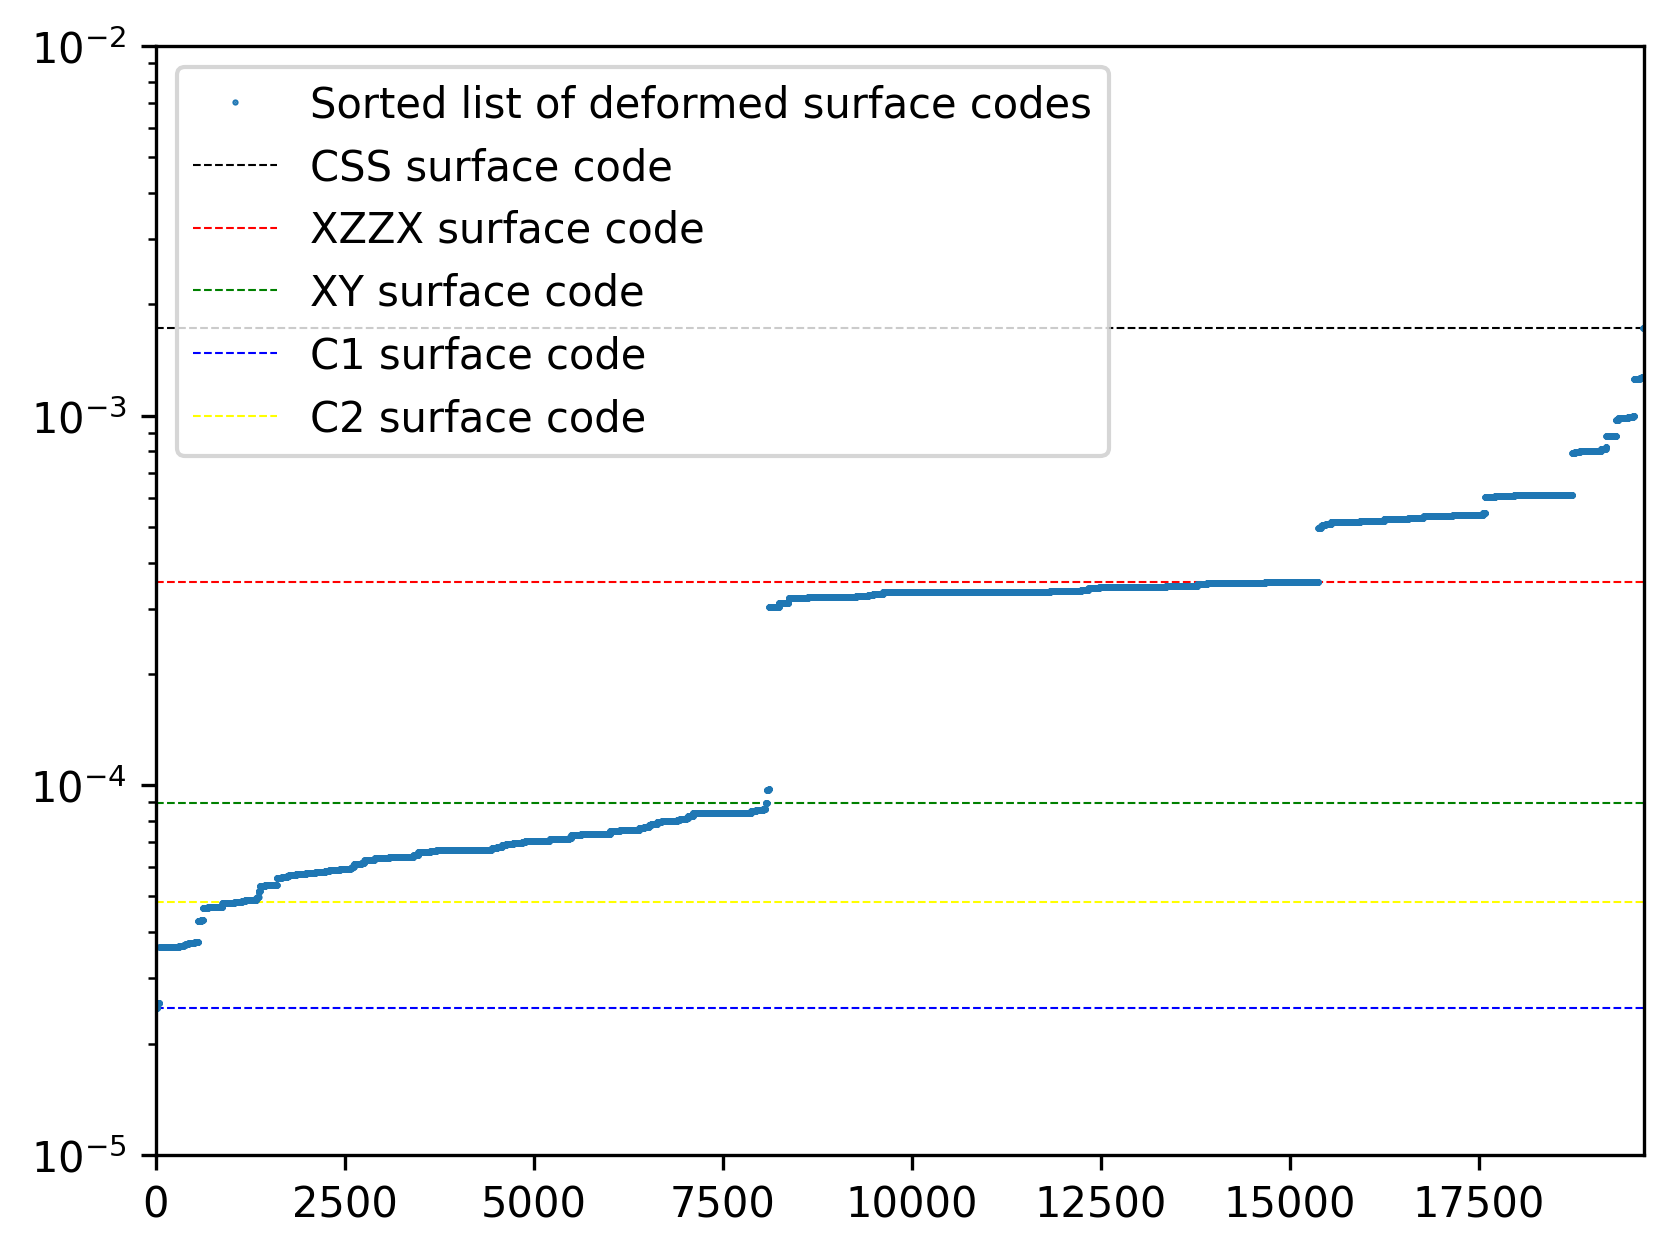

In [9]:
sorted_idx = all_logical_error_rates.argsort()
plt.figure(dpi=300)
plt.plot(
    jnp.arange(0, sorted_idx.shape[0]), 
    all_logical_error_rates[sorted_idx],
    '.', ms=1,
    label='Sorted list of deformed surface codes'
)
for d, spec in zip(
    jnp.array([
        [0,0,0,0,0,0,0,0,0],
        [3,0,3,0,3,0,3,0,3],
        [2,2,2,2,2,2,2,2,2],
        [2,0,2,3,2,3,2,0,2],
        [2,2,0,3,0,2,0,3,2],
    ]),
    [
        ("k", "CSS surface code"),
        ("red", "XZZX surface code"),
        ("green", "XY surface code"),
        ("blue", "C1 surface code"),
        ("yellow", "C2 surface code"),
    ]
):
    idx = jnp.dot(jnp.array([0,0,1,2])[d], 3**jnp.arange(9))
    plt.hlines([all_logical_error_rates[idx]], [0], [all_logical_error_rates.shape[0]], color=spec[0], ls='--', lw=.5, zorder=-1, label=spec[1])
plt.legend()
plt.yscale('log')
plt.ylim(1E-5, 1E-2)
plt.xlim(0, all_logical_error_rates.shape[0])
plt.show()

In [11]:
jnp.save(
    "data/Error_rate_of_clifford_deformations_012_prob_01_nu_500",
    all_logical_error_rates
)

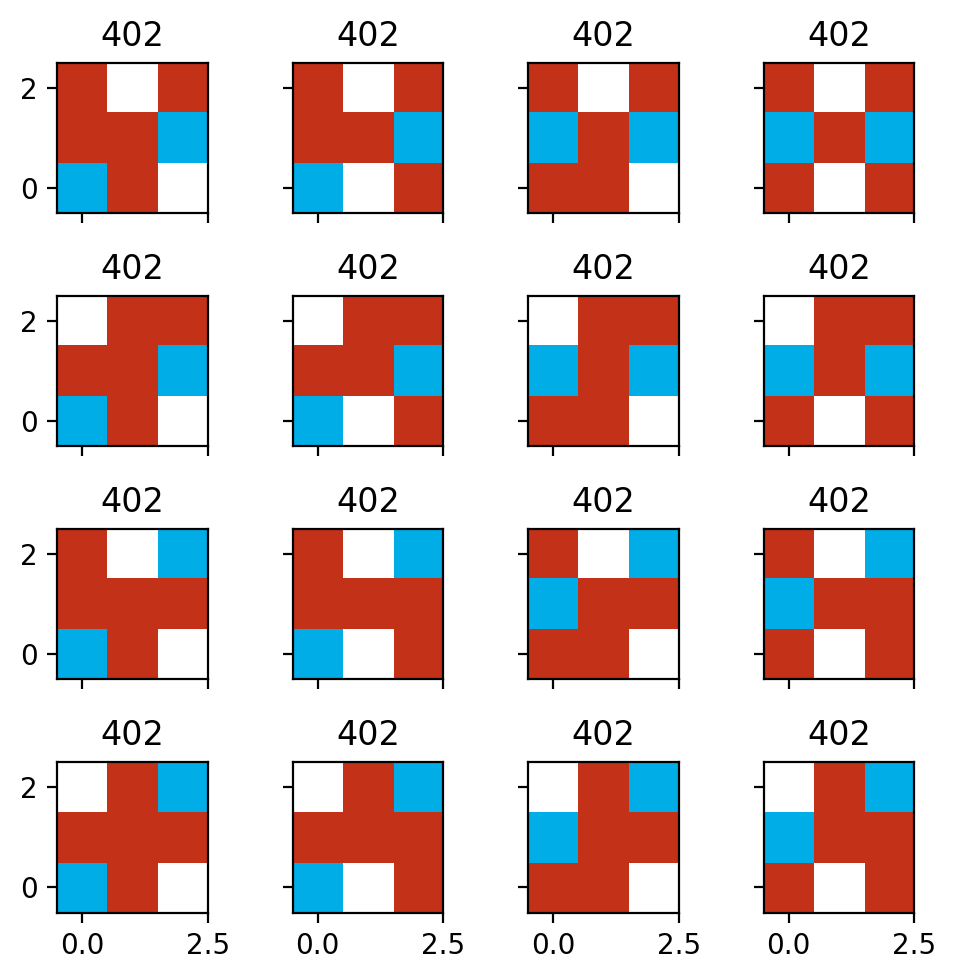

In [12]:
from matplotlib.colors import ListedColormap
deformation_cmap = ListedColormap([
    "#FFFFFF", # I
    "#88C946", # X-Y
    "#C43119", # Y-Z
    "#00ADE7", # X-Z
    "#833794", # X-Y-Z
    "#FFB94C", # X-Z-Y
])

fig, ax = plt.subplots(4,4, sharex=True, sharey=True, dpi=200)
fig.set_figwidth(5)
fig.set_figheight(5)
for i, idx_row in enumerate(jnp.where(all_logical_error_rates < 2.5E-5)[0].reshape(4,4)):
    for j, idx in enumerate(idx_row):
        ax[i][j].set_title(f"{-jnp.log(.99)/all_logical_error_rates[idx]:.0f}")
        ax[i][j].imshow(all_deformations[idx].reshape((3,3)), origin='lower', vmin=0, vmax=5, cmap=deformation_cmap)
plt.tight_layout()